# Why High-Performing Models Can Still Lead to Poor Decisions

# Introduction
In many real world machine learning systems, model performance is evaluated primarily through predictive metrics such as accuracy, precision-recal or ROC-AUC. While these metrics measure how well a model predicts an outcome, they do not account for how predictions are translated into decisions.

In practice, predictions are rarely acted upon directly. They are filtered through decision rules such as thresholds, prioritization schemes, capacity constraints or tiered actions. As a result, two systems using the same trained model can produce very different real world outcomes, solely due to differences in decision design.

This creates a critical gap in applied machine learning: high predictive performance does not guarantee high impact.

## Objective of This Case Study
The objective of this case study is to demonstrate that:

- A single fixed prediction model can lead to significantly different downstream outcomes

- These differences arise not from model quality, but from how predictions are operationalized into decisions

- Evaluating ML systems solely on predictive metrics can be misleading when real-world constraints and objectives are ignored

Rather than improving the model itself, this study focuses on evaluating decision strategies built on top of identical predictions.

## Approach
To isolate the effect of decision-making from prediction quality, we'll adopt a controlled experimental setup:
1. Generate a synthetic but realistic dataset representing risk prediction
2. Train a single binary classification model and keep it fixed throughout the study
3. Use the model’s predicted probabilities as inputs to multiple decision strategies, including:
   - fixed thresholding
   - tiered intervention policies
   - capacity-constrained ranking

4. Compare outcomes using impact-focused metrics such as:
   - number of successful interventions
   - missed high-risk cases
   - resource utilization efficiency

By holding the model constant, any observed differences in outcomes can be attributed solely to the decision logic.

## Why this Case Study matters
Most machine learning workflows stop at model evaluation but real world success is measured by outcomes, not predictions. This case study shows how decision rules can amplify or weaken a model’s signal and how thoughtful decision design can outperform naive thresholding even with the same model. It reframes ML systems as end-to-end decision pipelines, shifting the focus from “How accurate is the model?” to “What outcomes does it actually produce?”

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3MWFsZnNtbnhwaXVvZGphcjhieGhzb2Y3MTF1cHRlcGd3a29naG54YiZlcD12MV9zdGlja2Vyc19zZWFyY2gmY3Q9cw/zzGETTCgQlYHypN47M/giphy.gif)

## 1. Problem Formulation & Assumptions

### Prediction Task
We consider a binary risk prediction problem where the goal is to estimate the probability of a future adverse event. For this case study, we'll frame it as **predicting student disengagement**, though the setup generalizes to domains such as churn or fraud prediction.

The model outputs a probability score:
\[
\hat{p} = P(\text{disengagement} \mid \text{features})
\]

This prediction remains fixed throughout the study.

---

### Decision Context
Model predictions are not acted upon directly. Instead, they are passed through a **decision layer** that determines who receives an intervention under real world constraints such as limited resources.

The decision logic operates **on top of the same predictions** and varies across strategies.

---

### Key Assumptions
- The prediction model is fixed after training  
- Predicted probabilities can be interpreted as relative risk  
- Interventions increase the chance of preventing disengagement but are not always successful  
- Resources for intervention are limited  

---

### Evaluation Focus
Rather than evaluating predictive performance alone, we compare **downstream outcomes** produced by different decision strategies while keeping the model unchanged.


## 2. Synthetic Data Generation

To study the effect of decision strategies in a controlled setting, we generate a synthetic dataset where the true data-generating process is known.

Each data point represents a student with observable features and a latent disengagement risk.

---

### Data Design
We simulate:
- continuous behavioral features (e.g., engagement level, attendance trend)
- a binary ground-truth outcome indicating disengagement
- a probabilistic relationship between features and outcome

This allows us to:
- control risk distributions,
- avoid real-world data noise,
- and focus purely on prediction vs decision effects.

---

### Why Synthetic Data?
Using synthetic data ensures that:
- the ground truth is known,
- results are reproducible,
- and differences in outcomes arise from **decision logic**, not data artifacts.


In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 2000

# Simulated features
engagement_score = np.random.normal(0, 1, N)
attendance_trend = np.random.normal(0, 1, N)
assignment_delay = np.random.normal(0, 1, N)

# True risk (latent)
logits = (-0.8 * engagement_score - 0.6 * attendance_trend +0.9 * assignment_delay)
true_risk = 1 / (1 + np.exp(-logits))

# Ground truth outcome
disengaged = np.random.binomial(1, true_risk)

data = pd.DataFrame({"engagement_score": engagement_score,"attendance_trend": attendance_trend,"assignment_delay": assignment_delay,"true_risk": true_risk,"disengaged": disengaged})

data.head()


,engagement_score,attendance_trend,assignment_delay,true_risk,disengaged
0,0.496714,-0.675178,-0.863494,0.316607,0
1,-0.138264,-0.144519,-0.031203,0.542209,1
2,0.647689,-0.792420,0.018017,0.493379,0
3,1.523030,-0.307962,0.472630,0.352452,0
4,-0.234153,-1.893615,-1.366858,0.523313,0


The generated dataset consists of three continuous behavioral features, a latent risk score, and a binary disengagement outcome. A brief inspection shows that feature values are smoothly distributed, true risk spans the [0,1] range, and disengagement is probabilistically rather than deterministically linked to risk. This introduces realistic uncertainty into the data, making it suitable for training a probabilistic prediction model instead of a rule based system.

## 3. Model Training: Prediction Layer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Features and target
X = data[["engagement_score", "attendance_trend", "assignment_delay"]]
y = data["disengaged"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
auc = roc_auc_score(y_test, y_pred_proba)
auc


np.float64(0.7792134081196581)

The logistic regression model achieves a ROC-AUC of **0.78**, indicating good discriminative ability in ranking students by disengagement risk. While the model is not perfect, it provides a sufficiently informative risk signal for downstream decision-making.

At this point, the model is **frozen**. All subsequent analysis uses the same predicted probabilities to evaluate how different decision strategies affect real-world outcomes.


## 4. Freezing Predictions & Decision Strategy Design

With the prediction model trained and evaluated, we now freeze its outputs. From this point onward, the model is treated as a fixed component, and only the decision logic built on top of its predictions is allowed to vary.

This separation allows us to study how different decision strategies—applied to the same risk scores lead to different outcomes.


In [3]:
# Freeze predicted probabilities
results = X_test.copy()
results["true_label"] = y_test.values
results["risk_score"] = y_pred_proba

results.head()


,engagement_score,attendance_trend,assignment_delay,true_label,risk_score
1860,-0.134309,-0.451949,1.243406,1,0.831568
353,-0.159939,-1.365956,-1.672894,0,0.331605
1333,1.490726,0.574071,1.193311,0,0.336176
905,0.046437,0.750579,0.928246,0,0.588614
1289,-2.152891,-0.288039,0.910418,1,0.958399


### Decision Strategies

We evaluate three commonly used decision strategies that reflect real-world operational choices.

**1. Fixed Threshold Strategy**  
Intervene only when the predicted risk exceeds a predefined threshold.

**2. Tiered Intervention Strategy**  
Apply different levels of intervention depending on the predicted risk range.

**3. Capacity-Constrained Ranking Strategy**  
Intervene on the top-k highest-risk individuals, reflecting limited resources.


In [4]:
# Strategy 1: Fixed threshold
results["decision_threshold"] = (results["risk_score"] > 0.7).astype(int)

# Strategy 2: Tiered intervention
def tiered_strategy(p):
    if p > 0.8:
        return "high"
    elif p > 0.6:
        return "medium"
    elif p > 0.4:
        return "low"
    else:
        return "none"

results["decision_tiered"] = results["risk_score"].apply(tiered_strategy)

# Strategy 3: Capacity-constrained (top 50 risks)
top_k = 50
results["decision_topk"] = 0
top_indices = results["risk_score"].nlargest(top_k).index
results.loc[top_indices, "decision_topk"] = 1

results.head()


,engagement_score,attendance_trend,assignment_delay,true_label,risk_score,decision_threshold,decision_tiered,decision_topk
1860,-0.134309,-0.451949,1.243406,1,0.831568,1,high,0
353,-0.159939,-1.365956,-1.672894,0,0.331605,0,none,0
1333,1.490726,0.574071,1.193311,0,0.336176,0,none,0
905,0.046437,0.750579,0.928246,0,0.588614,0,low,0
1289,-2.152891,-0.288039,0.910418,1,0.958399,1,high,1


### Frozen Predictions and Decision Assignments

The table above shows the fixed predicted risk scores generated by the trained model, along with the corresponding decisions produced by each strategy. While the underlying risk scores remain identical across strategies, the resulting decisions differ substantially depending on the decision logic applied.

This highlights a key distinction: the model provides a continuous risk signal, but the decision layer determines how that signal is operationalized—whether through hard thresholds, tiered actions, or capacity-based prioritization. From this point onward, any differences in outcomes arise solely from these decision rules, not from changes in the prediction model.


## 5. Outcome Simulation & Impact Evaluation

Predictions alone do not change outcomes. Impact occurs only when a decision leads to an effective intervention.

In this section, we simulate intervention outcomes to evaluate how different decision strategies—applied to the same predictions—translate into real-world results.


In [5]:
# Simulate intervention success
np.random.seed(42)

def simulate_outcome(true_label, intervened, success_prob=0.6):
    """
    If a true disengaged student is intervened on,
    there is a probability of preventing disengagement.
    """
    if true_label == 1 and intervened == 1:
        return np.random.binomial(1, success_prob)
    return 0


In [6]:
# Apply outcome simulation for each strategy
results["outcome_threshold"] = results.apply(lambda x: simulate_outcome(x["true_label"], x["decision_threshold"]),axis=1)

results["outcome_topk"] = results.apply(lambda x: simulate_outcome(x["true_label"], x["decision_topk"]),axis=1)

# For tiered strategy: intervene on low/medium/high
results["tiered_intervened"] = results["decision_tiered"].isin(["low", "medium", "high"]).astype(int)

results["outcome_tiered"] = results.apply(lambda x: simulate_outcome(x["true_label"], x["tiered_intervened"]),axis=1)


### Impact Metrics

We now evaluate each strategy using outcome-focused metrics:
- total interventions made
- successful preventions
- missed disengaged cases

These metrics reflect system-level performance rather than model accuracy.
}

In [7]:
def summarize_strategy(df, decision_col, outcome_col):
    return {
        "interventions": df[decision_col].sum(),
        "successful_preventions": df[outcome_col].sum(),
        "missed_cases": ((df["true_label"] == 1) & (df[decision_col] == 0)).sum()
    }

summary = pd.DataFrame.from_dict({
    "Fixed Threshold": summarize_strategy(results, "decision_threshold", "outcome_threshold"),
    "Tiered Strategy": summarize_strategy(results, "tiered_intervened", "outcome_tiered"),
    "Top-K Strategy": summarize_strategy(results, "decision_topk", "outcome_topk")
}, orient="index")

summary


,interventions,successful_preventions,missed_cases
Fixed Threshold,146,72,172
Tiered Strategy,316,124,75
Top-K Strategy,50,28,244


### Outcome Comparison Across Decision Strategies

Despite using the same prediction model, the three decision strategies produce markedly different outcomes.

The **fixed threshold strategy** limits interventions, resulting in moderate successful preventions but a high number of missed disengaged cases.  
The **tiered strategy** intervenes more broadly, leading to the highest number of successful preventions while substantially reducing missed cases, at the cost of increased intervention volume.  
The **top-K strategy**, constrained by capacity, achieves efficiency per intervention but misses the majority of disengaged students due to strict prioritization.

These differences arise entirely from decision design rather than model performance, demonstrating that prediction quality alone is insufficient to determine system-level impact.


## Visual Comparison of Decision Outcomes

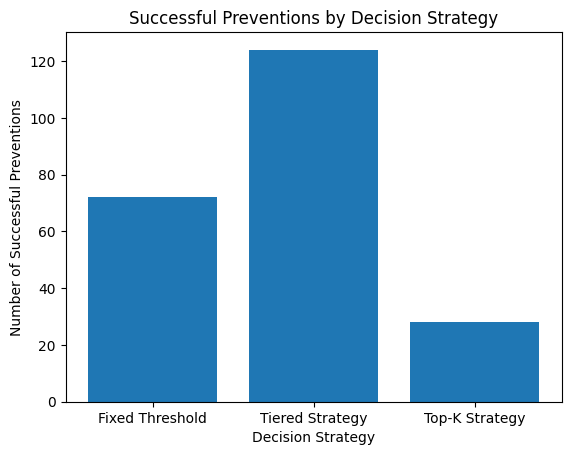

In [8]:
# Successful Preventions by Strategy
import matplotlib.pyplot as plt

strategies = summary.index
successful = summary["successful_preventions"]

plt.figure()
plt.bar(strategies, successful)
plt.title("Successful Preventions by Decision Strategy")
plt.ylabel("Number of Successful Preventions")
plt.xlabel("Decision Strategy")
plt.show()


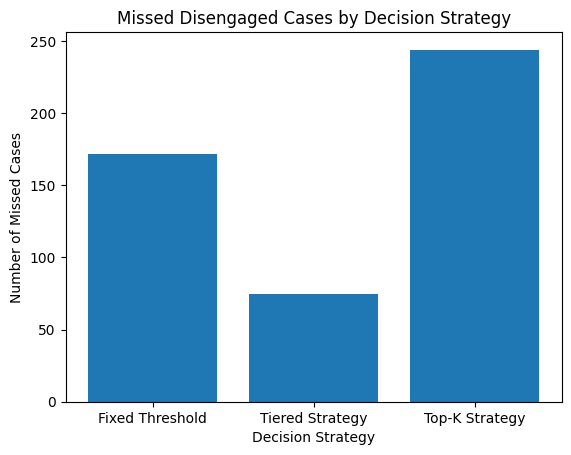

In [9]:
# Missed Disengaged Cases
missed = summary["missed_cases"]

plt.figure()
plt.bar(strategies, missed)
plt.title("Missed Disengaged Cases by Decision Strategy")
plt.ylabel("Number of Missed Cases")
plt.xlabel("Decision Strategy")
plt.show()


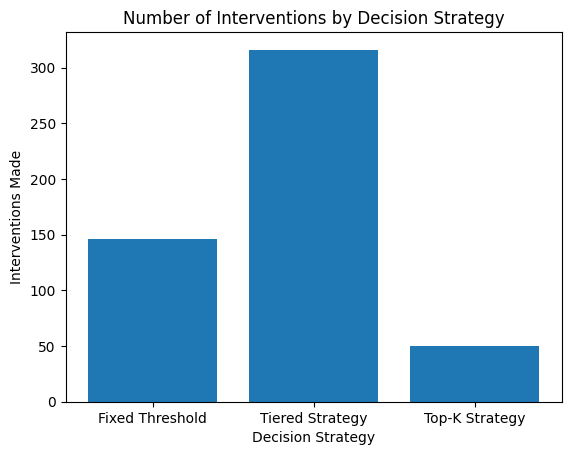

In [10]:
# Interventions Made vs Impact
interventions = summary["interventions"]

plt.figure()
plt.bar(strategies, interventions)
plt.title("Number of Interventions by Decision Strategy")
plt.ylabel("Interventions Made")
plt.xlabel("Decision Strategy")
plt.show()


### Interpreting the Visual Results

The plots make the impact of decision design explicit. Although all strategies rely on the same prediction model, their outcomes differ sharply. The tiered strategy achieves the highest number of successful preventions by intervening earlier and more broadly, while also minimizing missed disengaged cases. In contrast, the fixed threshold approach balances intervention cost and impact but leaves a substantial number of at-risk students untreated. The top-K strategy is the most resource-efficient, yet its strict capacity constraint leads to the highest number of missed cases.

These trade-offs are invisible when evaluating the model using predictive metrics alone, but become immediately apparent when the system is assessed at the outcome level.


This case study illustrates that model accuracy determines what we *know*, but decision design determines what we *change*.
